Text(0, 0.5, 'Amplitude')

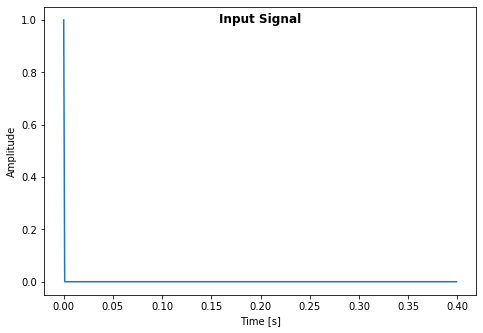

In [51]:
# Filter experiments

import math
import cmath
import numpy
import scipy
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline


#Ok, first will construct a waveform.  Then I can interpolate (upsample).  Finally I will filter.

#Make a 150Hz sine wave, sample at 1kHz
fs = 1000  #original sample frequency
m = 0
signal = []
while m < 400:
    #signal.append((math.sin(2*math.pi*800/fsamp*m))+(math.sin(2*math.pi*1600/fsamp*m))+(math.sin(2*math.pi*2400/fsamp*m))+(math.sin(2*math.pi*3200/fsamp*m))+(math.sin(2*math.pi*4000/fsamp*m)))
    #signal.append(math.sin(2*math.pi*250/fs*m))
    signal.append(0)
    m += 1

signal[0] = 1    
signalaxis = []
m = 0
while m < len(signal):
    signalaxis.append(m/fs)
    m += 1
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(signalaxis,signal)

fig.suptitle('Input Signal', fontweight='bold') 
ax.set_xlabel('Time [s]') 
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

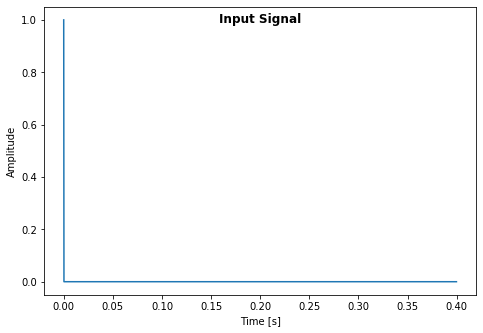

In [52]:
#Ok, signal is made.  Now let us interpolate to fs = 4kHz

#define interpolation rate
interp = 4

m = 0
intsignal = []

while m < len(signal):
    n = 0
    intsignal.append(signal[m])
    while n < interp - 1:
        intsignal.append(0)
        n += 1
    m += 1
    
intsignalaxis = []
m = 0
while m < len(intsignal):
    intsignalaxis.append(m/(interp * fs))
    m += 1
    
#Plot the new signal
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(intsignalaxis,intsignal)

fig.suptitle('Input Signal', fontweight='bold') 
ax.set_xlabel('Time [s]') 
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

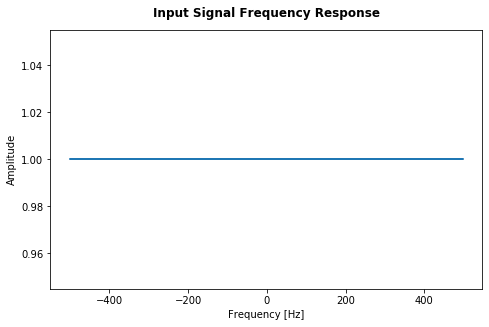

In [53]:
#Now I should compare the spectrum of the two signals

#Frequency response of input signal

wavefreq = abs(scipy.fft(signal))
freqaxis = []

freqaxis = list(numpy.fft.fftfreq(len(signal), d=1/fs))

fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(freqaxis,wavefreq)

fig.suptitle('Input Signal Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency [Hz]') 
ax.set_ylabel('Amplitude') 

Text(0, 0.5, 'Amplitude')

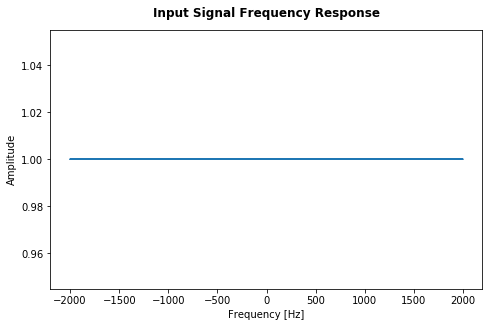

In [54]:
#Frequency response of interpolated input signal

intwavefreq = abs(scipy.fft(intsignal))
intfreqaxis = []

intfreqaxis = list(numpy.fft.fftfreq(len(intsignal), d=1/(interp*fs)))

fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(intfreqaxis,intwavefreq)

fig.suptitle('Input Signal Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency [Hz]') 
ax.set_ylabel('Amplitude') 

48

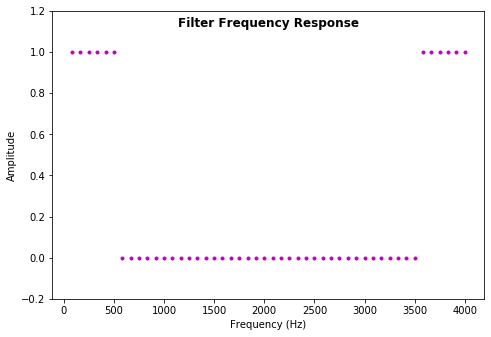

In [55]:
#Now want to construct a FIR filter to filter out anything below 500Hz, the original fs/2


N = 48  #number of samples in DFT
fmax = fs/2  #max unaliased frequency
bins = interp*fs/N  #size of DFT frequency bins

#construct FIR filter sequence
numbins = fs/2/bins
waveform = []
waveaxis = []
i = 0
while i < N/2:
    if i < numbins:
        waveform.append(1)
    else:
        waveform.append(0)
    i += 1
    waveaxis.append(bins*i)
if (N/2 % 2) == 0:
    k = N/2 + 1
else:
    k = N/2
i = 1
j = len(waveform)
while i < k:
    waveform.append(waveform[j - i])
    waveaxis.append((j)*bins+bins*i)
    i += 1


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(waveaxis,waveform,'m.')

fig.suptitle('Filter Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency (Hz)') 
ax.set_ylabel('Amplitude')
ax.set_ylim(-.2,1.2)
len(waveform)

(-0.2, 1.2)

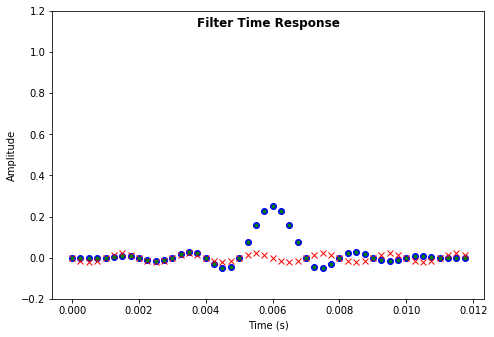

In [56]:
# Ok, next step is to take inverse DFT of filter to get time domain version

timewave = []
timewave = list(scipy.ifft(waveform))

ts = 1/(fs*interp)  #sample length in time(s)
i = 0
timeaxis = []
while i < len(timewave):
    timeaxis.append(i*ts)
    i += 1

i = 0
while i < len(timewave)/2:
    timewave.append(timewave.pop(0))
    i += 1
    
realwave = []
imagwave = []
i = 0
while i < len(timewave):
    realwave.append(timewave[i].real)
    imagwave.append(timewave[i].imag)
    i += 1

    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(timeaxis,realwave,'bo')
ax.plot(timeaxis,imagwave,'rx')
ax.plot(timeaxis,timewave,'g.')

fig.suptitle('Filter Time Response', fontweight='bold') 
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Amplitude')
ax.set_ylim(-.2,1.2)

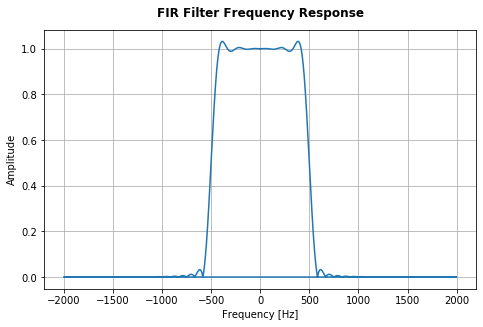

In [57]:
#Implement the filter

delayvalues = [0]*N
output = []
i = 0
while i < len(intsignal):
    j = 0
    sumval = 0
    delayvalues[0] = intsignal[i]
    while j < len(delayvalues):
        sumval = sumval + delayvalues[j]*realwave[j]
        j += 1
    j = 0
    output.append(sumval)
    while j < (len(delayvalues)-1):
        delayvalues[len(delayvalues)-1-j] = delayvalues[len(delayvalues)-2-j]
        j += 1
    i += 1    

#convert to frequency and graph
wavefreq = list((abs(scipy.fft(output))))
freqaxis = []

freqaxis = list(numpy.fft.fftfreq(len(wavefreq), d=1/(fs*interp)))

fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(freqaxis,wavefreq)

fig.suptitle('FIR Filter Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency [Hz]') 
ax.set_ylabel('Amplitude') 
#ax.set_ylim(0,100)
ax.grid()

In [58]:
#I see no sign that I need a normalization factor, which I find odd.